# Generative Adversarial Networks

In this homework you will experiment with the [Deep Convolutional Generative Adversarial Network (DCGAN)](https://arxiv.org/pdf/1511.06434.pdf) for representation learning and image generation.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

## Data loading and pre-processing

Here we download and unpack the Frey dataset.  The dataset consists of grayscale images, 28 pixels high and 20 pixels wide.

In [2]:
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

path = get_file('frey_rawface.mat','https://cs.nyu.edu/~roweis/data/frey_rawface.mat')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))
np.random.seed(1234)
np.random.shuffle(images)
x_train = (images.astype('float32')/255.)*2-1
x_train = np.expand_dims(x_train,axis=-1)

ImportError: Traceback (most recent call last):
  File "c:\users\eric\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "c:\users\eric\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "c:\users\eric\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "c:\users\eric\anaconda3\envs\tensorflow-gpu\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "c:\users\eric\anaconda3\envs\tensorflow-gpu\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

(1965, 28, 20)


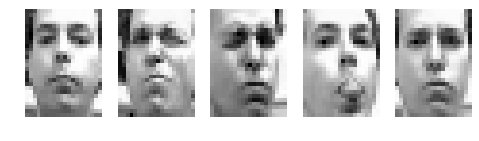

In [10]:
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

## Model implementation and training

I have given the implementation of the DCGAN here.  It is a bit tricky to set up with Keras.

In [14]:
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, Conv2DTranspose, Reshape, Lambda, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K

from tqdm.autonotebook import trange

def get_generator():
  """ Builds the generator network that converts noise into images. """
  
   # Input is a 100-dimensional latent vector
  inputs = Input((100,))
  
  # Fully-connected layer to transform noise into a tensor
  x = Dense(7*5*64,activation='relu')(inputs) 
  
  # Reshape into a 4x4x512 tensor
  x = Reshape((7,5,64))(x)
  
  # Transposed convolutions to upsample tensor
  x = Conv2DTranspose(32,4,strides=2,activation=None,padding='same')(x)
  x = LeakyReLU(alpha=0.1)(x)

  outputs = Conv2DTranspose(1,4,strides=2,activation='tanh',padding='same')(x)
  
  return Model(inputs=inputs,outputs=outputs)
   
def get_discriminator():
  """ Builds the discriminator network which tries to discriminate real images from fakes. """
  # Input is a 64x64 image
  inputs = Input((28,20,1))
  
  # Strided convolutions to downsample
  x = Conv2D(32,4,strides=2,activation=None,padding='same')(inputs)  
  x = LeakyReLU(alpha=0.1)(x)
  x = Conv2D(64,4,strides=2,activation=None,padding='same')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Final output with sigmoid activation for binary classification
  x = Flatten()(x)
  outputs = Dense(1,activation='sigmoid')(x)
  
  return Model(inputs=inputs,outputs=outputs)

def setup_gan_training(generator,discriminator):
  g_opt = Adam(lr=0.0002,beta_1=0.5,beta_2=0.999,epsilon=1e-3)
  d_opt = Adam(lr=0.0002,beta_1=0.5,beta_2=0.999,epsilon=1e-3)

  generator.compile(loss='binary_crossentropy',optimizer=g_opt)
  discriminator.compile(loss='binary_crossentropy',optimizer=d_opt)

  discriminator.trainable = False
  inputs = Input((100,))
  x = generator(inputs)
  outputs = discriminator(x)
  
  d_on_g = Model(inputs=inputs,outputs=outputs)
  d_on_g.compile(loss='binary_crossentropy',optimizer=g_opt)
  
  return d_on_g

def sample_from_generator(generator):
  noise_input = np.random.normal(size=(32,100))
  x_fake = np.squeeze(generator.predict(noise_input))
  n = 0
  for i in range(4):
    for j in range(8):
      plt.subplot(4,8,n+1)
      plt.imshow(x_fake[n])
      plt.axis('off')
      n = n+1
  plt.show()

def train_gan(generator, discriminator, d_on_g,
              x, num_epochs=100, batch_size=64):
  num_batches = len(x) // batch_size
    
  gen_loss_history = []
  discrim_loss_history = []
    
  for i in range(num_epochs):
    inds = np.arange(len(x))
    np.random.shuffle(inds)
        
    for j in trange(num_batches):
      noise_input = np.random.normal(size=(batch_size, 100))
            
      x_real = x[inds[(j*batch_size):((j+1)*batch_size)]]
      y_real = [1]*batch_size

      x_fake = generator.predict(noise_input, batch_size=batch_size)
      y_fake = [0]*batch_size

      discriminator.trainable = True
      real_loss = discriminator.train_on_batch(x_real, y_real)
      fake_loss = discriminator.train_on_batch(x_fake, y_fake)
      discrim_loss = 0.5*(real_loss + fake_loss)
      
      x_generator = np.random.normal(size=(batch_size, 100))
      y_generator = [1]*batch_size
      discriminator.trainable = False
      gen_loss = d_on_g.train_on_batch(x_generator, y_generator)

      gen_loss_history.append(gen_loss)
      discrim_loss_history.append(discrim_loss)
    print('epoch %d: discriminator loss: %.2f\tgenerator loss: %.2f'%(i+1,discrim_loss,gen_loss))
    sample_from_generator(generator)
    
  return gen_loss_history, discrim_loss_history

generator = get_generator()
discriminator = get_discriminator()
d_on_g = setup_gan_training(generator,discriminator)

print(generator.summary())
print(discriminator.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2240)              226240    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 5, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 10, 32)        32800     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 10, 32)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 20, 1)         513       
Total params: 259,553
Trainable params: 259,553
Non-trainable params: 0
_________________________________________________________________
None

In [15]:
gen_loss_history, discrim_loss_history = train_gan(generator,discriminator,d_on_g,x_train)

Output hidden; open in https://colab.research.google.com to view.

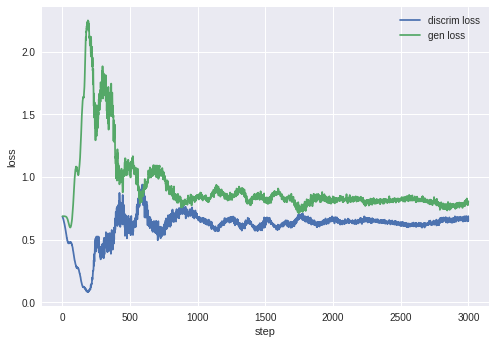

In [23]:
plt.plot(discrim_loss_history)
plt.plot(gen_loss_history)
plt.xlabel('step')
plt.ylabel('loss')
plt.legend(['discrim loss','gen loss'])
plt.show()

## Exercises

* Try to improve the DCGAN -- can you get the reconstructed images to look sharper and less noisy?  Possible things to try: change # of parameters in generator discriminator; change type of optimzer / learning rate; change batch size or other hyperparameters.
* Do you see evidence of mode collapse in the results of GAN training?  Does the generator seem to be able to generate everything that is in the training set?
* Try the Least Squares GAN (LSGAN) -- this simply means changing the loss function to be mean squared error rather than binary crossentropy.  Is there any effect on the GAN training or results?
* Train a DCGAN on the LFW dataset and analyze the results.  I put a loader below which resizes and crops to 28x20.

Archive:  /root/.keras/datasets/lfwcrop_grey.zip
replace lfwcrop_grey/lists/07_test_same.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
(13233, 28, 20)


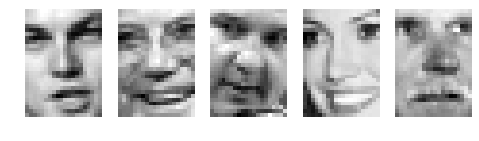

In [22]:
from tensorflow.keras.utils import get_file
import cv2
import glob

# download cropped images from LFW
path = get_file('lfwcrop_grey.zip','http://conradsanderson.id.au/lfwcrop/lfwcrop_grey.zip')

# unzip them
!unzip /root/.keras/datasets/lfwcrop_grey.zip

# load all images
def load_and_crop(path):
  im = cv2.imread(path,0)
  im = cv2.resize(im,(28,28))
  im = im[:,4:-4]
  return im
images = np.stack([load_and_crop(path) for path in glob.glob('lfwcrop_grey/faces/*.pgm')])

# change to [-1 1] range
x_train = (images.astype('float32')/255.)*2-1
x_train = np.expand_dims(x_train,axis=-1)

# show images
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()